In [ ]:
!pip install datasets

   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 480.6/480.6 kB 29.7 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 116.3/116.3 kB 9.0 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 179.3/179.3 kB 15.6 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 134.8/134.8 kB 10.5 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 194.1/194.1 kB 15.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver

In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset
from torch.nn.utils import prune

# Cargar modelo BERT base preentrenado y tokenizer
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Cargar conjunto de datos
# Este dataset contiene frases extra√≠das de rese√±as de pel√≠culas
# y est√° etiquetado para el an√°lisis de sentimientos. Cada frase
# est√° asociada con una eitqueta que indica si el sentimiento expresado
# es positivo o negativo
dataset = load_dataset("glue", "sst2")
encoded_dataset = dataset.map(
    lambda examples: tokenizer(examples['sentence'], truncation=True, padding='max_length'), batched=True
)

# Separar en conjuntos de entrenamiento y prueba
train_dataset = encoded_dataset["train"]
test_dataset = encoded_dataset["validation"]

# Funci√≥n para evaluar el modelo
def evaluate_model(model, dataset):
    trainer = Trainer(
        model=model,  # El modelo que ser√° evaluado
        eval_dataset=dataset,  # Conjunto de datos para evaluaci√≥n
        tokenizer=tokenizer,
    )
    eval_results = trainer.evaluate()  # Realiza la evaluaci√≥n
    return eval_results  # Devuelve las m√©tricas de evaluaci√≥n

# Configuraci√≥n del entrenamiento
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
)

# Crear el Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
)

# Evaluar modelo antes del pruning
print("Evaluaci√≥n antes del pruning:")
eval_before = evaluate_model(model, test_dataset)
print(eval_before)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of ü§ó Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-4-71dfe692718e>:48: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
<ipython-input-4-71dfe692718e>:27: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Evaluaci√≥n antes del pruning:


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ¬∑¬∑¬∑¬∑¬∑¬∑¬∑¬∑¬∑¬∑


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


{'eval_loss': 0.7274540662765503, 'eval_model_preparation_time': 0.007, 'eval_runtime': 1958.9374, 'eval_samples_per_second': 0.445, 'eval_steps_per_second': 0.056}


Para aplicar pruning en BERT, debemos reducir el n√∫mero de par√°metros eliminando conexiones o capas innecesarias de la red. Este enfoque puede incluir:

1. Reducci√≥n del n√∫mero de capas del codificador (n_layers)
2. Reducci√≥n del n√∫mero de cabezas de atenci√≥n multi-cabecera (n_heads)
3. Reducci√≥n de dimensiones de embedding (d_model, d_ff)
4. Eliminaci√≥n de neuronas no significativas en las capas lineales
5. Uso de t√©cnicas de sparsity (enmascarar pesos cercanos a cero)

In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset
from torch.nn.utils import prune

# Cargar modelo BERT base preentrenado y tokenizer
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Cargar conjunto de datos
# Este dataset contiene frases extra√≠das de rese√±as de pel√≠culas
# y est√° etiquetado para el an√°lisis de sentimientos. Cada frase
# est√° asociada con una eitqueta que indica si el sentimiento expresado
# es positivo o negativo
dataset = load_dataset("glue", "sst2")
encoded_dataset = dataset.map(
    lambda examples: tokenizer(examples['sentence'], truncation=True, padding='max_length'), batched=True
)

# Separar en conjuntos de entrenamiento y prueba
train_dataset = encoded_dataset["train"]
test_dataset = encoded_dataset["validation"]

# Funci√≥n para evaluar el modelo
def evaluate_model(model, dataset):
    trainer = Trainer(
        model=model,  # El modelo que ser√° evaluado
        eval_dataset=dataset,  # Conjunto de datos para evaluaci√≥n
        tokenizer=tokenizer,
    )
    eval_results = trainer.evaluate()  # Realiza la evaluaci√≥n
    return eval_results  # Devuelve las m√©tricas de evaluaci√≥n

def prune_bert(model, amount=0.3, prune_type='l1_unstructured', layers_to_prune=None):

    if layers_to_prune is None:
        # Si no se especifican capas, aplicamos pruning a todas las capas lineales
        layers_to_prune = [name for name, module in model.named_modules() if isinstance(module, torch.nn.Linear)]

    print(f"Aplicando pruning con {amount*100}% de reducci√≥n utilizando {prune_type} a las siguientes capas:")
    print(layers_to_prune)

    # Iterar sobre todas las capas especificadas y aplicar pruning
    for name, module in model.named_modules():
      # Aplicamos el pruning a las capas lineales porque son las capas que concentran
      # la mayor√≠a de los par√°metros, por ello reducir el n'√∫¬¥mero depesos en estas
      # capas tienen un impacto significativo
        if name in layers_to_prune and isinstance(module, torch.nn.Linear):
            print(f"Pruning en la capa: {name} ({module.__class__.__name__})")

            # Aplicar el tipo de pruning especificado
            if prune_type == 'l1_unstructured':
                prune.l1_unstructured(module, name="weight", amount=amount)
            elif prune_type == 'random_unstructured':
                prune.random_unstructured(module, name="weight", amount=amount)
            else:
                raise ValueError(f"Tipo de pruning '{prune_type}' no soportado.")

            # Consolidar pruning eliminando la m√°scara y dejando solo los pesos
            prune.remove(module, "weight")

    print("Pruning completado.")

# Aplicar pruning
prune_bert(model, amount=0.3)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Aplicando pruning con 30.0% de reducci√≥n utilizando l1_unstructured a las siguientes capas:
['bert.encoder.layer.0.attention.self.query', 'bert.encoder.layer.0.attention.self.key', 'bert.encoder.layer.0.attention.self.value', 'bert.encoder.layer.0.attention.output.dense', 'bert.encoder.layer.0.intermediate.dense', 'bert.encoder.layer.0.output.dense', 'bert.encoder.layer.1.attention.self.query', 'bert.encoder.layer.1.attention.self.key', 'bert.encoder.layer.1.attention.self.value', 'bert.encoder.layer.1.attention.output.dense', 'bert.encoder.layer.1.intermediate.dense', 'bert.encoder.layer.1.output.dense', 'bert.encoder.layer.2.attention.self.query', 'bert.encoder.layer.2.attention.self.key', 'bert.encoder.layer.2.attention.self.value', 'bert.encoder.layer.2.attention.output.dense', 'bert.encoder.layer.2.intermediate.dense', 'bert.encoder.layer.2.output.dense', 'bert.encoder.layer.3.attention.self.query', 'bert.encoder.layer.3.attention.self.key', 'bert.encoder.layer.3.attention.self.v

In [ ]:
# Evaluar modelo luego del pruning
print("Evaluaci√≥n luego del pruning:")
eval_after = evaluate_model(model, test_dataset)
print(eval_after)

Evaluaci√≥n luego del pruning:


<ipython-input-4-a439d14aa98f>:27: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
input_ids = torch.randint(0, 1000, (1, 128))
attention_mask = torch.ones_like(input_ids)

torch.onnx.export(
    model,
    (input_ids, attention_mask),
    "model_pruned.onnx",
    input_names=["input_ids", "attention_mask"],
    output_names=["logits"],
    dynamic_axes={
        "input_ids": {0: "batch_size", 1: "sequence_length"},
        "attention_mask": {0: "batch_size", 1: "sequence_length"},
    },
    opset_version=14,
)

In [ ]:
!pip install tensorflow==2.10.0 onnx==1.12.0 onnx-tf==1.10.0


  Using cached tensorflow-2.10.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.1 kB)
  Using cached gast-0.4.0-py3-none-any.whl.metadata (1.1 kB)
  Using cached keras-2.10.0-py2.py3-none-any.whl.metadata (1.3 kB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl.metadata (1.9 kB)
  Using cached protobuf-3.19.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (787 bytes)
  Using cached tensorboard-2.10.1-py3-none-any.whl.metadata (1.9 kB)
  Using cached tensorflow_estimator-2.10.0-py2.py3-none-any.whl.metadata (1.3 kB)
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 578.0/578.0 MB 1.2 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 13.1/13.1 MB 50.5 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î

In [ ]:
!pip install tensorflow-probability==0.18.0

   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6.6/6.6 MB 54.3 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-probability
    Found existing installation: tensorflow-probability 0.24.0
    Uninstalling tensorflow-probability-0.24.0:
      Successfully uninstalled tensorflow-probability-0.24.0


In [ ]:
!pip install --upgrade onnx-tf

In [ ]:
from tensorflow import keras
from onnx_tf.backend import prepare
import onnx

# Cargar el modelo ONNX
onnx_model = onnx.load("model_pruned.onnx")

# Convertir y guardar el modelo en formato TensorFlow
tf_rep = prepare(onnx_model)
tf_rep.export_graph("./tf_saved_model")

BackendIsNotSupposedToImplementIt: in user code:

    File "/usr/local/lib/python3.10/dist-packages/onnx_tf/backend_tf_module.py", line 99, in __call__  *
        output_ops = self.backend._onnx_node_to_tensorflow_op(onnx_node,
    File "/usr/local/lib/python3.10/dist-packages/onnx_tf/backend.py", line 347, in _onnx_node_to_tensorflow_op  *
        return handler.handle(node, tensor_dict=tensor_dict, strict=strict)
    File "/usr/local/lib/python3.10/dist-packages/onnx_tf/handlers/handler.py", line 61, in handle  *
        raise BackendIsNotSupposedToImplementIt("{} version {} is not implemented.".format(node.op_type, cls.SINCE_VERSION))

    BackendIsNotSupposedToImplementIt: Unsqueeze version 13 is not implemented.


In [ ]:
!pip install tf2onnx


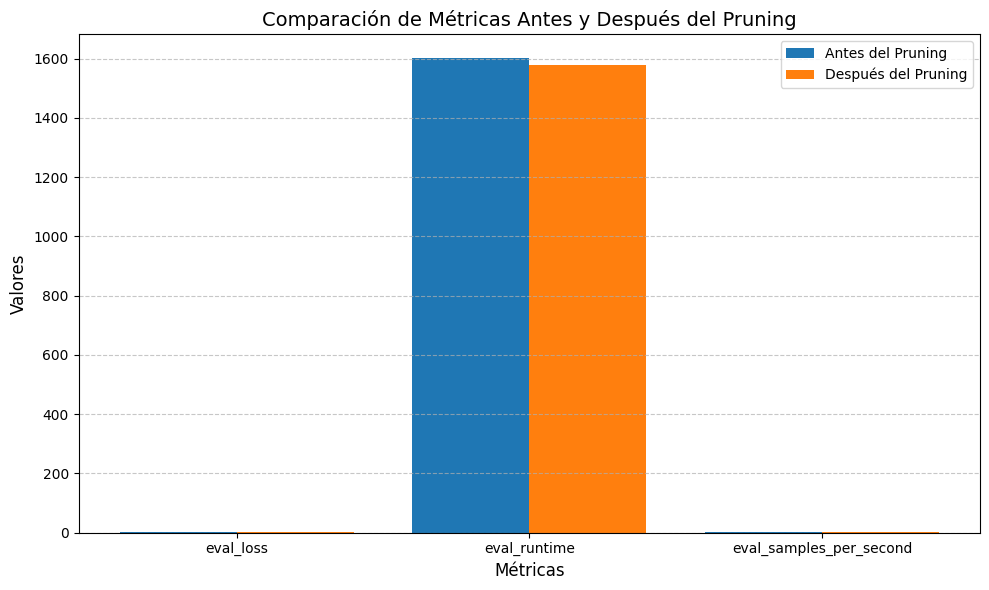

In [ ]:
import matplotlib.pyplot as plt

# Visualizaci√≥n de los resultados
def plot_comparison(eval_before, eval_after):
    """
    Genera un gr√°fico para comparar m√©tricas antes y despu√©s del pruning.
    """
    metrics = ['eval_loss', 'eval_runtime', 'eval_samples_per_second']

    # Extraer valores para las m√©tricas seleccionadas
    before_values = [eval_before[metric] for metric in metrics]
    after_values = [eval_after[metric] for metric in metrics]

    # Crear el gr√°fico
    x = range(len(metrics))
    plt.figure(figsize=(10, 6))
    plt.bar(x, before_values, width=0.4, label='Antes del Pruning', align='center')
    plt.bar([p + 0.4 for p in x], after_values, width=0.4, label='Despu√©s del Pruning', align='center')

    # Etiquetas y t√≠tulo
    plt.xlabel('M√©tricas', fontsize=12)
    plt.ylabel('Valores', fontsize=12)
    plt.title('Comparaci√≥n de M√©tricas Antes y Despu√©s del Pruning', fontsize=14)
    plt.xticks([p + 0.2 for p in x], metrics, fontsize=10)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Generar el gr√°fico
plot_comparison(eval_before, eval_after)

# A partir de aqu√≠ agregaremos el c√≥digo correspondiente al ENTREGABLE 2

La quantization es una t√©cnica utilizada para reducir la precisi√≥n de los par√°metros del modelo, con el objetivo de disminuir el tama√±o del modelo y mejorar la eficiencia computacional sin una p√©rdida significativa en la calidad de las predicciones. En lugar de usar representaciones de punto flotante (como float32), la quantization reduce los valoes a enteros de menor precisi√≥n, como int8, lo que disminiuye el uso de memoria y acelera la inferencia, especialmente en dispositivos con recursos limitados.

Importancia de la Quantization:

1.  Reducci√≥n del tama√±o del modelo: Disminuye la memoria utilizada, permitiendo que los modelos se ajusten a dispositivos con recursos limitados, como m√≥viles y dispositivos embebidos.
2.   Mejora de la Velocidad de Inferencia: La reducci√≥n de la precisi√≥n de los pesos permite realizar c√°lculos m√°s r√°pidos, lo que es crucial en entornos con recursos limitados
3. Optimizaci√≥n para Dispositivos de Baja Potencia: En dispositivos m√≥viles y sistemas con limitaciones de hardware, la quantization es fundamental para mejorar el rendimiento sin comprometer demasiado la precisi√≥n




In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.quantization import quantize_dynamic

# Aqu√≠ aplicaremos una quantization din√°mico al modelo podado, es decir, al modelo
# que hemos obtenido luego del pruning

model_quantized = quantize_dynamic(
    model, # Modelo bert podado, es decir, luego del pruning
    {torch.nn.Linear},  # Solo aplicamos quantization a las capas lineales
    # Hay varios motivos para aplicar la quantization a las capas lineales:
    # 1. Lsa capas lineales son responsables de la mayor parte del c√≥mputo en
    # muchos modelos de redes neuronales. Estas capas suelen realizar multiplicaciones
    # de matrices (una multiplicaci√≥n entre las activaciones y los pesos de la capa),
    # lo cual es una operaci√≥n muy costosa. Quantizar estas operaciones puede dar grandes mejoras
    # en eficiencia sin comprometer demasiado al rendimiento
    # 2. Hay sensibilidad a la precisi√≥n: Las capas lineales a menudo son m√°s
    # robustas a la p√©rdida de precisi√≥n cuando se cuantizan, ya que las multiplicaciones
    # de los valores de los pesos se pueden aproximar con enteros sin afectar significativamente los resultados,
    # siempre que el rango de valores de los pesos no sea demasiado amplio.

    dtype=torch.qint8    # Usamos int8 para la quantization
    # Los valoes de este tipo ocupan solo 1 byte (8 tips) por valor, en comparaci√≥n
    # con los valoers de tipo flotante de 32 bits, que ocupan 4 bytes, esto puede ser
    # beneficioso, porque con convertir los pesos de 32 bits a 8 bits podemos
    # reducir el tama√±o del modelo en un 75%, lo cual es una mejora sustancial
    # justamente para usarlo en dispositivos limitados
)

# Evaluar el modelo quantizado
print("Evaluaci√≥n con modelo quantizado:")
eval_after_quantization = evaluate_model(model_quantized, test_dataset)
print(eval_after_quantization)

Evaluaci√≥n con modelo quantizado:


<ipython-input-4-a439d14aa98f>:27: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


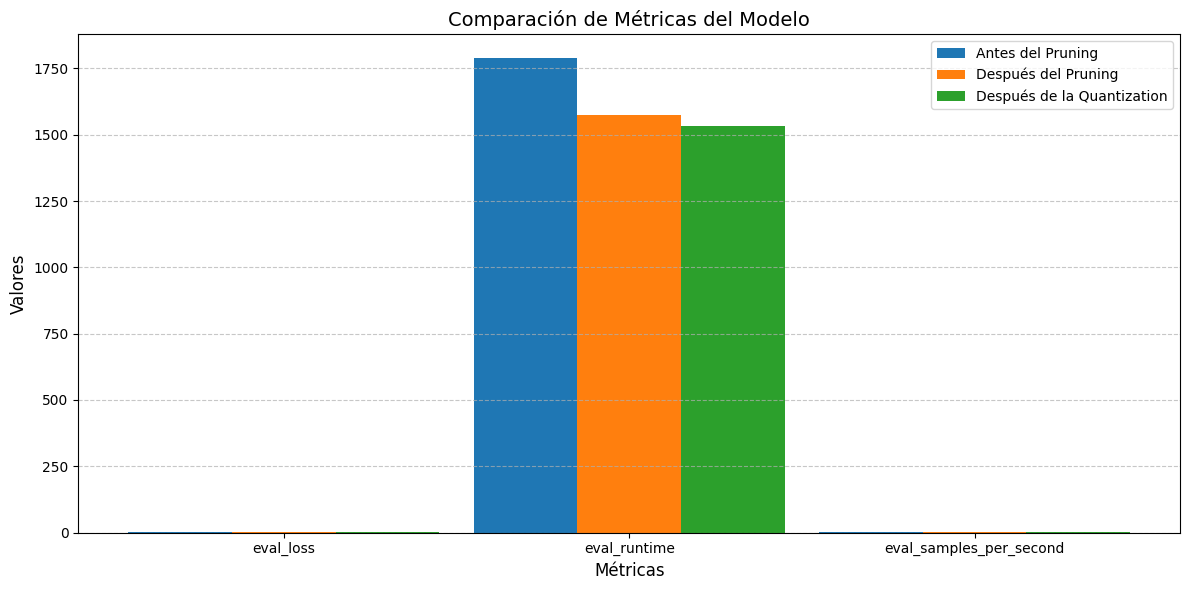

In [ ]:
import matplotlib.pyplot as plt

# Visualizaci√≥n de los resultados
# del modelo BERT original, luego del pruning y luego de aplicarle
# quantization

def plot_comparison(eval_before, eval_pruned, eval_quantized):
    """
    Genera un gr√°fico para comparar m√©tricas antes del pruning,
    despu√©s del pruning, y despu√©s de la quantization.
    """
    metrics = ['eval_loss', 'eval_runtime', 'eval_samples_per_second']

    # Extraer valores para las m√©tricas seleccionadas
    before_values = [eval_before[metric] for metric in metrics]
    pruned_values = [eval_pruned[metric] for metric in metrics]
    quantized_values = [eval_quantized[metric] for metric in metrics]

    # Crear el gr√°fico
    x = range(len(metrics))
    width = 0.3  # Ancho de las barras
    plt.figure(figsize=(12, 6))

    plt.bar([p - width for p in x], before_values, width=width, label='Antes del Pruning', align='center')
    plt.bar(x, pruned_values, width=width, label='Despu√©s del Pruning', align='center')
    plt.bar([p + width for p in x], quantized_values, width=width, label='Despu√©s de la Quantization', align='center')

    # Etiquetas y t√≠tulo
    plt.xlabel('M√©tricas', fontsize=12)
    plt.ylabel('Valores', fontsize=12)
    plt.title('Comparaci√≥n de M√©tricas del Modelo', fontsize=14)
    plt.xticks(x, metrics, fontsize=10)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Generar el gr√°fico
plot_comparison(eval_before, eval_pruned, eval_after_quantization)

In [ ]:
# Clase para garantizar entradas v√°lidas
class WrappedModel(torch.nn.Module):
    def __init__(self, model):
        super(WrappedModel, self).__init__()
        self.model = model

    def forward(self, input_ids, attention_mask):
        # Extrae solo los logits del diccionario de salida
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.logits  # Devuelve solo los logits

# Crear el modelo envuelto
wrapped_model = WrappedModel(model_quantized)

# Ejemplos de entrada
input_ids = torch.randint(0, 1000, (1, 128))  # Secuencia de ejemplo (batch_size=1, sequence_length=128)
attention_mask = torch.ones_like(input_ids)  # M√°scara de atenci√≥n

# Trazar el modelo envuelto
traced_model = torch.jit.trace(wrapped_model, (input_ids, attention_mask))
torch.jit.save(traced_model, "quantized_model.pt")
print("Modelo guardado en quantized_model.pt")

Modelo guardado en quantized_model.pt


In [ ]:
tokenizer.save_pretrained("./tokenizer")
print("Tokenizer guardado en ./tokenizer")

Tokenizer guardado en ./tokenizer


In [ ]:
from transformers import TFBertForSequenceClassification

# Cargar el modelo en formato TensorFlow
model_tf = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# Guardar el modelo como SavedModel
saved_model_path = "./tf_saved_model"
model_tf.save_pretrained(saved_model_path)

print(f"Modelo guardado en: {saved_model_path}")


In [ ]:
import torch
from torch import nn

class WrappedModel(nn.Module):
    def __init__(self, model):
        super(WrappedModel, self).__init__()
        self.model = model

    def forward(self, input_ids, attention_mask):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.logits  # Devuelve solo los logits

# Crear el modelo envuelto
wrapped_model = WrappedModel(model_quantized)

# Dummy input para exportar
dummy_input = {
    "input_ids": torch.randint(0, 1000, (1, 128)),  # Secuencia de ejemplo
    "attention_mask": torch.ones(1, 128),          # M√°scara de atenci√≥n de ejemplo
}

# Ruta para guardar el modelo ONNX
onnx_model_path = "quantized_model.onnx"

# Exportar a ONNX
torch.onnx.export(
    wrapped_model,  # Modelo envuelto
    (dummy_input["input_ids"], dummy_input["attention_mask"]),  # Entradas
    onnx_model_path,  # Ruta de salida
    input_names=["input_ids", "attention_mask"],  # Nombres de entrada
    output_names=["logits"],  # Nombre de salida
    dynamic_axes={"input_ids": {0: "batch_size", 1: "sequence_length"},
                  "attention_mask": {0: "batch_size", 1: "sequence_length"}},  # Dimensiones din√°micas
    opset_version=13  # Versi√≥n ONNX
)

print(f"Modelo exportado a ONNX: {onnx_model_path}")


UnsupportedOperatorError: Exporting the operator 'quantized::linear_dynamic' to ONNX opset version 13 is not supported. Please feel free to request support or submit a pull request on PyTorch GitHub: https://github.com/pytorch/pytorch/issues.

In [ ]:
!pip install onnxruntime



   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 13.3/13.3 MB 50.7 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 46.0/46.0 kB 3.6 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 86.8/86.8 kB 5.5 MB/s eta 0:00:00


In [ ]:
!pip install onnx onnxruntime onnxruntime-tools


   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 212.7/212.7 kB 14.6 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 55.5/55.5 kB 4.6 MB/s eta 0:00:00


In [ ]:
!python3 -m onnxruntime.tools.convert_onnx_models_to_ort model_pruned.onnx


Converting models with optimization style 'Fixed' and level 'all'
Converting optimized ONNX model /content/model_pruned.onnx to ORT format model /content/model_pruned.ort
Converted 1/1 models successfully.
Generating config file from ORT format models with optimization style 'Fixed' and level 'all'
2024-12-07 18:36:14,667 ort_format_model.utils [INFO] - Created config in /content/model_pruned.required_operators.config
Converting models with optimization style 'Runtime' and level 'all'
Converting optimized ONNX model /content/model_pruned.onnx to ORT format model /content/model_pruned.with_runtime_opt.ort
Converted 1/1 models successfully.
Converting models again without runtime optimizations to generate a complete config file. These converted models are temporary and will be deleted.
Converting optimized ONNX model /content/model_pruned.onnx to ORT format model /content/tmp4mbntm3c.without_runtime_opt/model_pruned.ort
Converted 1/1 models successfully.
Generating config file from ORT f

# A partir de aqu√≠ agregamos c√≥digo del 3er y √∫ltimo entregable

Knowledge Distillation: Es una t√©cnica en la que un modelo m√°s grande y complejo, conocido como Teacher, transfiere su conocimiento a un modelo m√°s peque√±o y eficiente, llamado Student. Este proceso permite que el modelo Student aprenda no solo de las etiquetas reales de los datos, sino tambi√©n de las "soft targets# generadas por el Teacher, que contienen informaci√≥n adicional sobre las relaciones entre las clases. Esta t√©cnica es especialmente √∫til para reducir el tama√±o de los modelos y optimizar su rendimiento en en dispositivos con recursos limitados

Importancia:
1. Permite crear modelos m√°s compactos que retienen la mayor parte del conocimiento del modelo original, haciendo posible si implementaci√≥n en dispositivos con restricciones de memoria y almacenamiento

2. Los modelos distilados suelen ser m√°s r√°pidos en la inferencia, lo que es crucial para aplciaciones en tiempo real en dispositivos m√≥vile o embedidos

3. Aunque el modelo Student es m√°s peque√±o, la distillation asegura que su rendimiento se acerque al del modelo Teacher, lo que lo hace eficiente sin una p√©rdida significativa de precisi√≥n

4. Transferencia de la informaci√≥n compleja:

In [ ]:
# Importar librer√≠as necesarias
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer, BertForSequenceClassification, DistilBertForSequenceClassification
from datasets import load_dataset
from torch.utils.data import DataLoader
from torch.nn.utils import prune

# Configuraciones iniciales
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Cargar tokenizer y conjunto de datos
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)

# Cargar dataset SST-2 de GLUE
dataset = load_dataset("glue", "sst2")
encoded_dataset = dataset.map(
    lambda examples: tokenizer(examples['sentence'], truncation=True, padding='max_length'), batched=True
)

# Preparar datos para DataLoader
train_dataset = encoded_dataset["train"]
test_dataset = encoded_dataset["validation"]

def preprocess_dataset(dataset):
    input_ids = torch.tensor(dataset["input_ids"])
    attention_mask = torch.tensor(dataset["attention_mask"])
    labels = torch.tensor(dataset["label"])
    return torch.utils.data.TensorDataset(input_ids, attention_mask, labels)

train_data = preprocess_dataset(train_dataset)
test_data = preprocess_dataset(test_dataset)

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

# Cargar modelo Teacher (BERT)
teacher_model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)
teacher_model.eval()

# Pruning del modelo Teacher
def prune_bert(model, amount=0.3, prune_type='l1_unstructured', layers_to_prune=None):
    if layers_to_prune is None:
        layers_to_prune = [name for name, module in model.named_modules() if isinstance(module, torch.nn.Linear)]

    print(f"Aplicando pruning con {amount*100}% de reducci√≥n utilizando {prune_type} a las siguientes capas:")
    print(layers_to_prune)

    for name, module in model.named_modules():
        if name in layers_to_prune and isinstance(module, torch.nn.Linear):
            print(f"Pruning en la capa: {name} ({module.__class__.__name__})")

            if prune_type == 'l1_unstructured':
                prune.l1_unstructured(module, name="weight", amount=amount)
            elif prune_type == 'random_unstructured':
                prune.random_unstructured(module, name="weight", amount=amount)
            else:
                raise ValueError(f"Tipo de pruning '{prune_type}' no soportado.")

            prune.remove(module, "weight")

    print("Pruning completado.")

prune_bert(teacher_model, amount=0.3)

# NUEVO: Cuantizaci√≥n del modelo Teacher
def quantize_model(model):
    model.eval()
    model = torch.quantization.quantize_dynamic(
        model,  # El modelo a cuantizar
        {torch.nn.Linear},  # Tipos de capas a cuantizar
        dtype=torch.qint8  # Tipo de datos utilizado en la cuantizaci√≥n
    )
    print("Modelo cuantizado.")
    return model

# Cuantizar el modelo Teacher
model_quantized = quantize_model(teacher_model)  # NUEVO

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/35.3k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/3.11M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/72.8k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/1821 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Aplicando pruning con 30.0% de reducci√≥n utilizando l1_unstructured a las siguientes capas:
['bert.encoder.layer.0.attention.self.query', 'bert.encoder.layer.0.attention.self.key', 'bert.encoder.layer.0.attention.self.value', 'bert.encoder.layer.0.attention.output.dense', 'bert.encoder.layer.0.intermediate.dense', 'bert.encoder.layer.0.output.dense', 'bert.encoder.layer.1.attention.self.query', 'bert.encoder.layer.1.attention.self.key', 'bert.encoder.layer.1.attention.self.value', 'bert.encoder.layer.1.attention.output.dense', 'bert.encoder.layer.1.intermediate.dense', 'bert.encoder.layer.1.output.dense', 'bert.encoder.layer.2.attention.self.query', 'bert.encoder.layer.2.attention.self.key', 'bert.encoder.layer.2.attention.self.value', 'bert.encoder.layer.2.attention.output.dense', 'bert.encoder.layer.2.intermediate.dense', 'bert.encoder.layer.2.output.dense', 'bert.encoder.layer.3.attention.self.query', 'bert.encoder.layer.3.attention.self.key', 'bert.encoder.layer.3.attention.self.v

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Cargar modelo Student (DistilBERT)
student_model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2).to(device)

# Configurar funciones de p√©rdida
criterion = nn.CrossEntropyLoss()  # P√©rdida est√°ndar para etiquetas duras
distillation_loss_fn = nn.KLDivLoss(reduction="batchmean")  # Para las soft targets

# Configurar optimizador
optimizer = optim.AdamW(student_model.parameters(), lr=5e-5)

# Funci√≥n para entrenar con Knowledge Distillation
def train_student(teacher, student, dataloader, epochs=3, alpha=0.5, temperature=2.0):
    teacher.eval()
    student.train()

    for epoch in range(epochs):
        total_loss = 0
        for input_ids, attention_mask, labels in dataloader:
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            with torch.no_grad():
                teacher_outputs = teacher(input_ids, attention_mask=attention_mask).logits
                teacher_probs = torch.softmax(teacher_outputs / temperature, dim=-1)

            student_outputs = student(input_ids, attention_mask=attention_mask).logits
            student_probs = torch.log_softmax(student_outputs / temperature, dim=-1)

            distillation_loss = distillation_loss_fn(student_probs, teacher_probs) * (temperature ** 2)
            classification_loss = criterion(student_outputs, labels)
            loss = alpha * distillation_loss + (1 - alpha) * classification_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss:.4f}")

# Entrenar el modelo Student usando el modelo Teacher cuantizado
train_student(model_quantized, student_model, train_loader)  # NUEVO: Usar el modelo cuantizado

# Evaluar el modelo Student
def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for input_ids, attention_mask, labels in dataloader:
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
            outputs = model(input_ids, attention_mask=attention_mask).logits
            predictions = torch.argmax(outputs, dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    print(f"Accuracy: {accuracy:.4f}")
    return accuracy

# Evaluar el modelo Student
print("Evaluaci√≥n del modelo Student:")
evaluate_model(student_model, test_loader)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


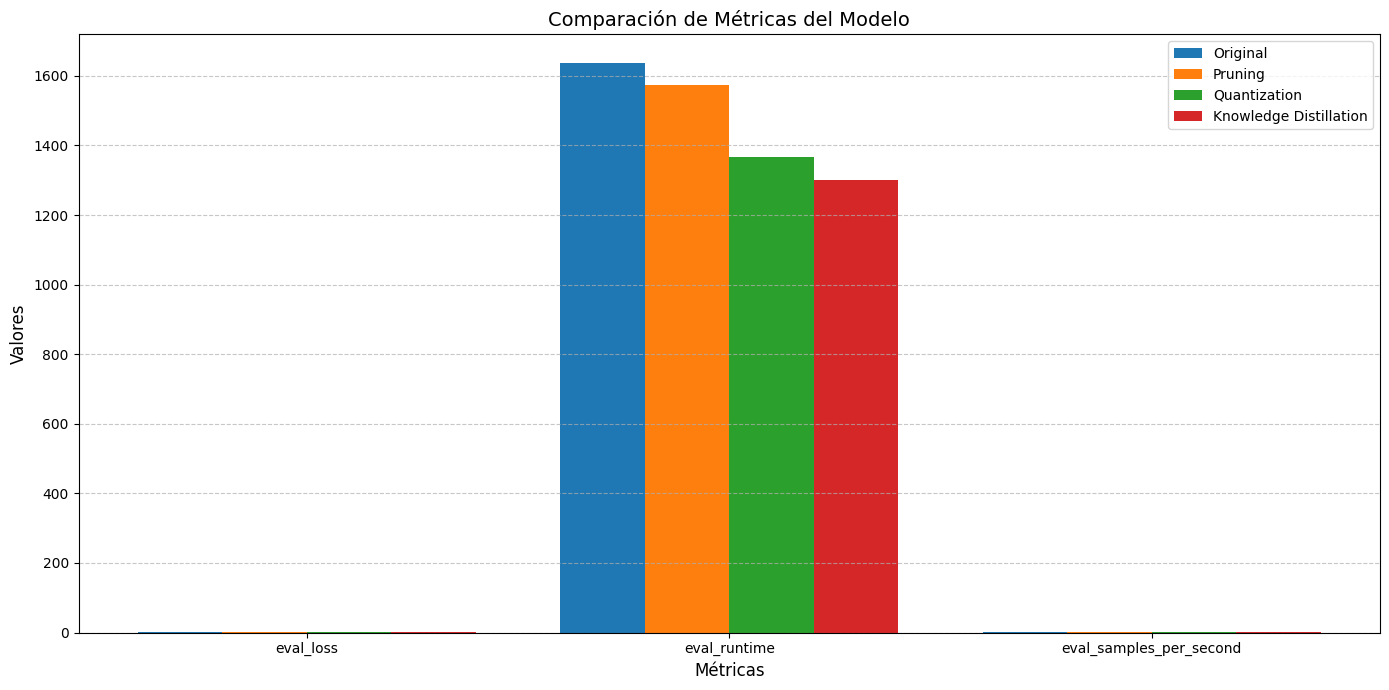

In [3]:
import matplotlib.pyplot as plt


def plot_comparison(eval_before, eval_pruned, eval_quantized, eval_after_knowledge_distillation):
    """
    Genera un gr√°fico para comparar m√©tricas antes del pruning,
    despu√©s del pruning, despu√©s de la quantization y tras Knowledge Distillation.
    """
    metrics = ['eval_loss', 'eval_runtime', 'eval_samples_per_second']

    # Extraer valores para las m√©tricas seleccionadas
    before_values = [eval_before[metric] for metric in metrics]
    pruned_values = [eval_pruned[metric] for metric in metrics]
    quantized_values = [eval_quantized[metric] for metric in metrics]
    distilled_values = [eval_after_knowledge_distillation[metric] for metric in metrics]

    # Crear el gr√°fico
    x = range(len(metrics))
    width = 0.2  # Ancho de las barras
    plt.figure(figsize=(14, 7))

    plt.bar([p - 1.5 * width for p in x], before_values, width=width, label='Original', align='center')
    plt.bar([p - 0.5 * width for p in x], pruned_values, width=width, label='Pruning', align='center')
    plt.bar([p + 0.5 * width for p in x], quantized_values, width=width, label='Quantization', align='center')
    plt.bar([p + 1.5 * width for p in x], distilled_values, width=width, label='Knowledge Distillation', align='center')

    # Etiquetas y t√≠tulo
    plt.xlabel('M√©tricas', fontsize=12)
    plt.ylabel('Valores', fontsize=12)
    plt.title('Comparaci√≥n de M√©tricas del Modelo', fontsize=14)
    plt.xticks(x, metrics, fontsize=10)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

plot_comparison(eval_before, eval_pruned, eval_quantized, eval_after_knowledge_distillation)